## For single Fits File

1024


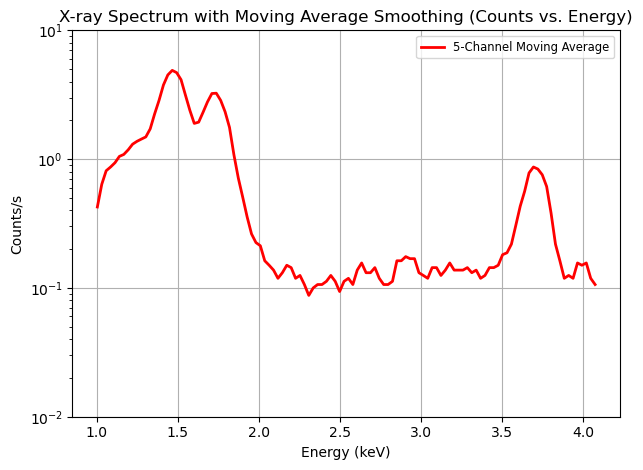

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

def moving_average(data, window_size):
    """Compute the moving average using a specified window size."""
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

def process_and_plot_fits(data_directory, background_file=None, window_size=10):
    """
    Processes all .fits files in the specified directory and plots Counts vs. Energy,
    along with a moving average curve for smoothed visualization.

    Parameters:
    - data_directory (str): Path to the directory containing .fits files.
    - background_file (str, optional): Path to a background .fits file for background subtraction.
    - window_size (int, optional): Window size for the moving average.
    """

    # Load the background data if specified
    background_counts = None
    if background_file:
        with fits.open(background_file) as bg_hdul:
            bg_data = bg_hdul[1].data
            background_counts = bg_data['COUNTS']

    fits_file = '/mnt/c/Users/r9307/interIIT/ch2_class_pds_release_38_20240927/cla/miscellaneous/ch2_class_x2abund_lmodel_v1.0/X2ABUND_LMODEL_V1/test/ch2_cla_l1_20210827T210316000_20210827T210332000_1024.fits'
    
    with fits.open(fits_file) as hdul:
        spectrum_data = hdul[1].data
        channels = spectrum_data['CHANNEL']
        print(len(channels))
        counts = spectrum_data['COUNTS']

    # Calculate energy for each channel
    energy = np.array([13.58 * (2048/len(channels)) * c / 1000 for c in channels])
    counts = np.array([c / 32 for c in counts])

    # Filter channels between 37 and 800
    valid_indices = (channels >= 37) & (channels <= 150)
    channels = channels[valid_indices]
    energy = energy[valid_indices]
    counts = counts[valid_indices]

    # Perform background subtraction if background counts are available
    if background_counts is not None:
        background_counts = background_counts[valid_indices]
        summed_counts -= background_counts

    # Compute moving average on the filtered summed_counts
    smoothed_counts = moving_average(counts, window_size)

    # Plot raw counts and smoothed (moving average) counts vs. Energy
    plt.plot(energy, smoothed_counts, label=f'{window_size}-Channel Moving Average', color='red', linewidth=2)

    # Configure plot labels and title
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts/s')
    plt.yscale('log')
    plt.ylim(0.01, 10)
    plt.title('X-ray Spectrum with Moving Average Smoothing (Counts vs. Energy)')
    plt.legend(loc='upper right', fontsize='small')
    plt.grid()
    plt.tight_layout()
    plt.show()

    return (energy, smoothed_counts)

# Example usage:
data_directory = '/mnt/c/Users/r9307/interIIT/Working Dir'
energy, smoothed_counts = process_and_plot_fits(data_directory, background_file=None, window_size=5)


## For Directory

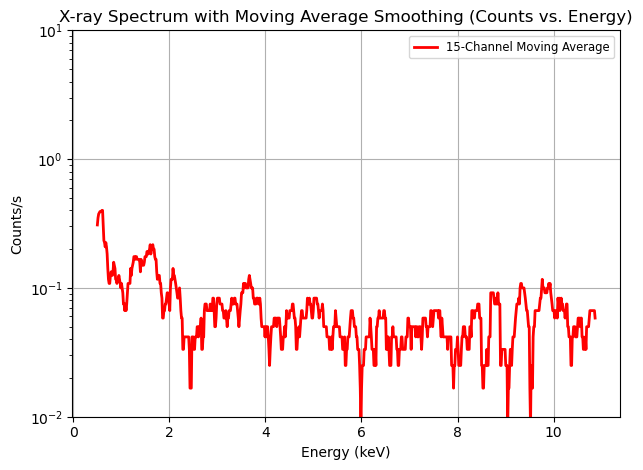

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

def moving_average(data, window_size):
    """Compute the moving average using a specified window size."""
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

def process_and_plot_fits(data_directory, background_file=None, window_size=10):
    """
    Processes all .fits files in the specified directory and plots Counts vs. Energy,
    along with a moving average curve for smoothed visualization.

    Parameters:
    - data_directory (str): Path to the directory containing .fits files.
    - background_file (str, optional): Path to a background .fits file for background subtraction.
    - window_size (int, optional): Window size for the moving average.
    """

    # Initialize counts array for summing up all files
    summed_counts = np.zeros(2048)

    # Load the background data if specified
    background_counts = None
    if background_file:
        with fits.open(background_file) as bg_hdul:
            bg_data = bg_hdul[1].data
            background_counts = bg_data['COUNTS']

    # Iterate over all .fits files in the data directory
    for filename in os.listdir(data_directory):
        if filename.endswith('.fits'):
            file_path = os.path.join(data_directory, filename)
            with fits.open(file_path) as hdul:
                spectrum_data = hdul[1].data
                channels = spectrum_data['CHANNEL']
                counts = spectrum_data['COUNTS']
                summed_counts += counts


    # Calculate energy for each channel
    energy = np.array([13.58 * c / 1000 for c in channels])
    summed_counts_s = np.array([c / 8 for c in counts])

    # Filter channels between 37 and 800
    valid_indices = (channels >= 37) & (channels <= 800)
    channels = channels[valid_indices]
    energy = energy[valid_indices]
    summed_counts_s = summed_counts_s[valid_indices]

    # Perform background subtraction if background counts are available
    if background_counts is not None:
        background_counts = background_counts[valid_indices]
        summed_counts -= background_counts

    # Compute moving average on the filtered summed_counts
    smoothed_counts = moving_average(summed_counts_s, window_size)

    # Plot raw counts and smoothed (moving average) counts vs. Energy
    # plt.plot(energy, summed_counts, label='Summed Spectrum', alpha=0.5)
    plt.plot(energy, smoothed_counts, label=f'{window_size}-Channel Moving Average', color='red', linewidth=2)

    # Configure plot labels and title
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts/s')
    plt.yscale('log')
    plt.ylim(0.01, 10)
    plt.title('X-ray Spectrum with Moving Average Smoothing (Counts vs. Energy)')
    plt.legend(loc='upper right', fontsize='small')
    plt.grid()
    plt.tight_layout()
    plt.show()

    return (energy, smoothed_counts)

# Example usage:
data_directory = '/mnt/c/Users/r9307/interIIT/Working Dir'
energy, smoothed_counts = process_and_plot_fits(data_directory, background_file=None, window_size=15)


## Identify peaks (Gaussian)

0.7657894736842105


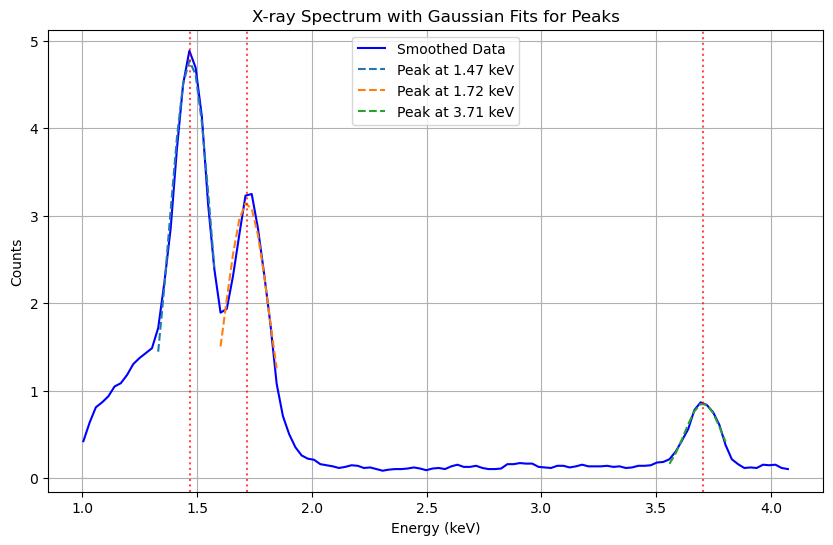

Peak 1: mu = 1.47 keV, sigma = 0.09 keV
Peak 2: mu = 1.72 keV, sigma = 0.10 keV
Peak 3: mu = 3.71 keV, sigma = 0.08 keV


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

# Gaussian function for fitting
def gaussian(x, a, mu, sigma):
    return a * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def identify_and_fit_peaks(energy, smoothed_counts, window_size=5):
    """
    Identifies peaks and fits a Gaussian curve to each peak in the smoothed data.

    Parameters:
    - energy (np.array): Energy values in keV.
    - smoothed_counts (np.array): Smoothed counts data.
    - window_size (int): Number of data points around the peak to consider for fitting.

    Returns:
    - peaks_info (list): A list containing (mu, sigma) for each identified peak.
    """
    # Identify peaks
    # smoothed_counts = gaussian_filter1d(smoothed_counts, sigma=2)
    mean_count = np.mean(smoothed_counts)
    std_count = np.std(smoothed_counts)
    threshold = mean_count
    print(threshold)
    peaks, _ = find_peaks(smoothed_counts, height=threshold, distance=10)  # Adjust height & distance as needed
    peaks_info = []

    plt.figure(figsize=(10, 6))
    plt.plot(energy, smoothed_counts, label='Smoothed Data', color='blue')

    for peak in peaks:
        # Select data around the peak for fitting
        start = max(0, peak - window_size)
        end = min(len(energy), peak + window_size)
        energy_window = energy[start:end]
        counts_window = smoothed_counts[start:end]

        # Initial guess for Gaussian parameters: amplitude, mean, and standard deviation
        initial_guess = [np.max(counts_window), energy[peak], 0.1]

        try:
            # Perform Gaussian fit
            popt, _ = curve_fit(gaussian, energy_window, counts_window, p0=initial_guess)
            a, mu, sigma = popt

            # Store peak info (mu and sigma)
            peaks_info.append((mu, sigma))

            # Plot the fitted Gaussian
            fitted_curve = gaussian(energy_window, *popt)
            plt.plot(energy_window, fitted_curve, label=f'Peak at {mu:.2f} keV', linestyle='--')
            plt.axvline(mu, color='red', linestyle=':', alpha=0.7)  # Mark peak location
        except RuntimeError:
            print(f"Gaussian fit failed for peak at index {peak}")

    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.title('X-ray Spectrum with Gaussian Fits for Peaks')
    plt.legend()
    plt.grid()
    plt.show()

    return peaks_info

# Example usage with smoothed energy and smoothed_counts data
# Assuming `energy` and `smoothed_counts` arrays are already available
peaks_info = identify_and_fit_peaks(energy, smoothed_counts)

# Display peak information
for i, (mu, sigma) in enumerate(peaks_info):
    print(f"Peak {i+1}: mu = {mu:.2f} keV, sigma = {sigma:.2f} keV")
